In [1]:
import sys
sys.path.append('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github')


In [2]:

# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import numpy as np
import pandas as pd
import random
import math
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df

!pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristic import NumericHeuristic5
from pct.tree.splitter.splitter import Splitter
from pct.tree.tree import Tree
import scipy.sparse as sp


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
data = pd.read_csv("/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/ml-1m/ratings.txt",sep='::',index_col=False,names=["user_id","item_id","rating","timestamp"],header=None,engine='python')
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
# Iteratively filters out users and items with fewer than the threshold number of interactions until no changes happen.
data = threshold_interactions_df(data,'user_id','item_id',100,100)

Starting interactions info
Number of rows: 6040
Number of cols: 3706
Sparsity: 4.468%
Ending interactions info
Number of rows: 2828
Number of columns: 1919
Sparsity: 14.284%


In [4]:
all_user_ids = sorted(data['user_id'].unique())
warm_users = all_user_ids[:1414]
cold_users = all_user_ids[1414:]


df_warm = data[data['user_id'].isin(warm_users)].copy()
df_cold = data[data['user_id'].isin(cold_users)].copy()


In [5]:
matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating"
)


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix(
    df_cold, "user_id", "item_id", "rating"
)

In [6]:
al, train_cold_K, _ = train_test_split(matrix_cold, 1)


X_cold, test_cold, _ = train_test_split(al, 30)

In [7]:
# Create combined user index mapping
combined_idx_to_rid = {
    **idx_to_rid_warm,  # Original warm user indices
    **{k + len(idx_to_rid_warm): v for k, v in idx_to_rid_cold.items()}  # Offset cold user indices
}


## Approach 2
#### KX = matrix_warm.copy() + train.copy() + X.copy()

In [12]:
def elicitation_by_tree_warm_max_performance(
    
    train,              # lil_matrix: cold users' known ratings (1 item/user, updated over rounds)
    test,               # lil_matrix: cold users' test ratings (30 ratings/user), fixed
    X,                  # lil_matrix: cold users' "hidden" ratings, revealed 1 per round
    matrix_warm,        # lil_matrix: warm users' full ratings
    idx_to_rid_cold,    # cold user index → user_id
    idx_to_rid_warm,    # warm user index → user_id
    idx_to_cid,         # item index → item_id
    iteration=5
):
    """
    Method 2: Retrain tree each round using warm + cold user data.
    Walk i steps for each cold user to reach a node and elicit a new rating.

    Returns:
    - rmse_list: RMSE after each iteration
    - mae_list: MAE after each iteration
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    # train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)

    # KX is the matrix of warm, cold train and cold X
    cold_KX = train.copy() + X.copy()
    warm_coldKX = sp.vstack([matrix_warm.copy(), cold_KX.copy()])
    warm_coldKX_copy = warm_coldKX.tolil().copy()
    KX_df = matrix_to_df_2(warm_coldKX_copy, combined_idx_to_rid, idx_to_cid) # Use combined mapping for KX_df

    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD using only cold-start (1 rating per user)
    reader = Reader(rating_scale=(1, 5))
    algo = SVD()
    KXtrainset = Dataset.load_from_df(KX_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    algo.fit(KXtrainset)

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    

     # Step 1: Prepare tree training data (warm + updated cold)
    # warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
    # cold_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
    # x_df = pd.concat([warm_df, cold_df], ignore_index=False)

    # tree_model = tree_model_class(max_depth=i+1, min_instances=5)
    # tree_model.fit(x_df, x_df)


       

    return rmse_list, mae_list


In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

max_performance =elicitation_by_tree_warm_max_performance(

    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    # iteration=8
)

RMSE: 0.8783
MAE:  0.6876
✅ Baseline evaluation complete.


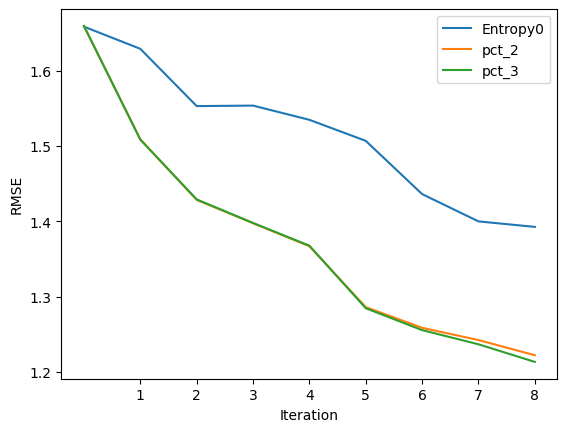

In [ ]:
x = np.arange(0,9) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, entropy0[0], label='Entropy0')
# ax1.plot(x, helf_1[0], label='helf')
# ax1.plot(x, variance_1[0], label='variance')
ax1.plot(x, pct_2[0], label='pct_2')
# ax1.plot(x, pct_3[0], label='pct_3')

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 9)) 
plt.show()

# plt.xticks(x, list_i)